🔹 CSV 파일 로드 중...
train: (1570, 2), meta: (17, 2), folds: (1570, 3), sample: (3140, 2)
train columns: ['ID', 'target']
meta columns: ['target', 'class_name']
✅ label_col = target
✅ id_col = ID


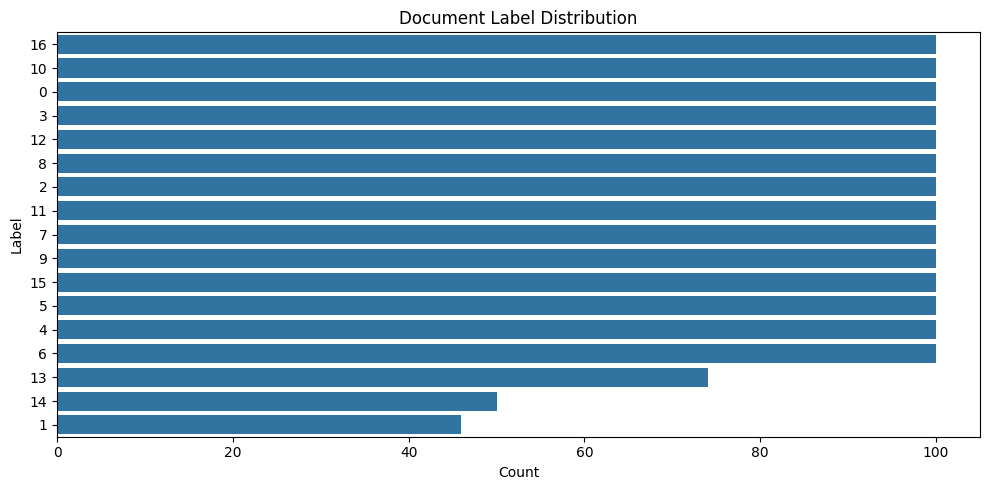

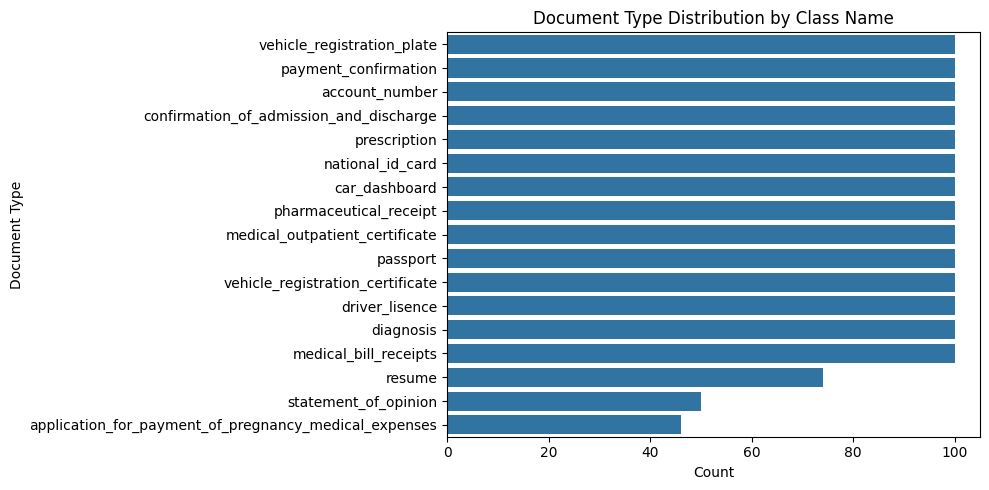


🔹 이미지 크기 분석 중...


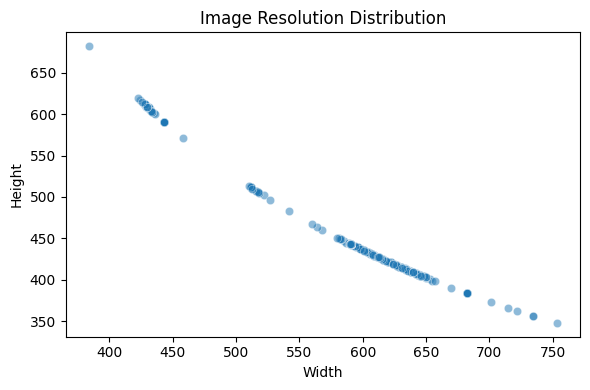

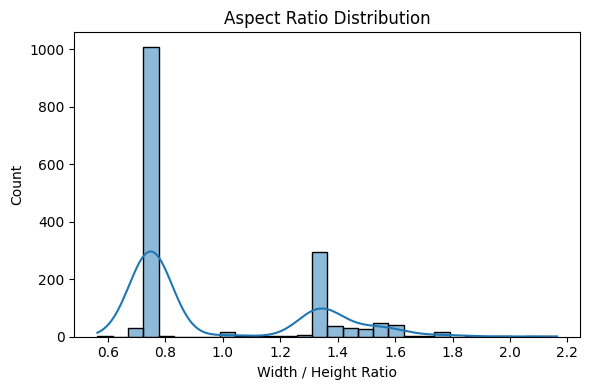

📏 평균 해상도: 497.6 x 538.2


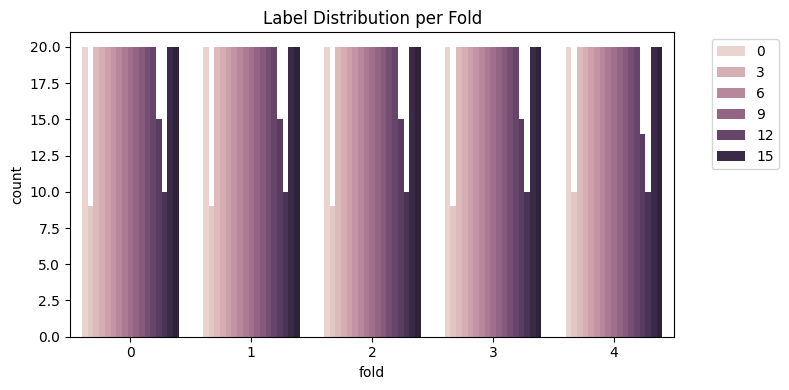


🔹 Train/Test 비교
Train 이미지 수: 1570
Test  이미지 수: 3140
Train ID 예시: 002f99746285dfdd.jpg
Test  ID 예시: 0008fdb22ddce0ce.jpg


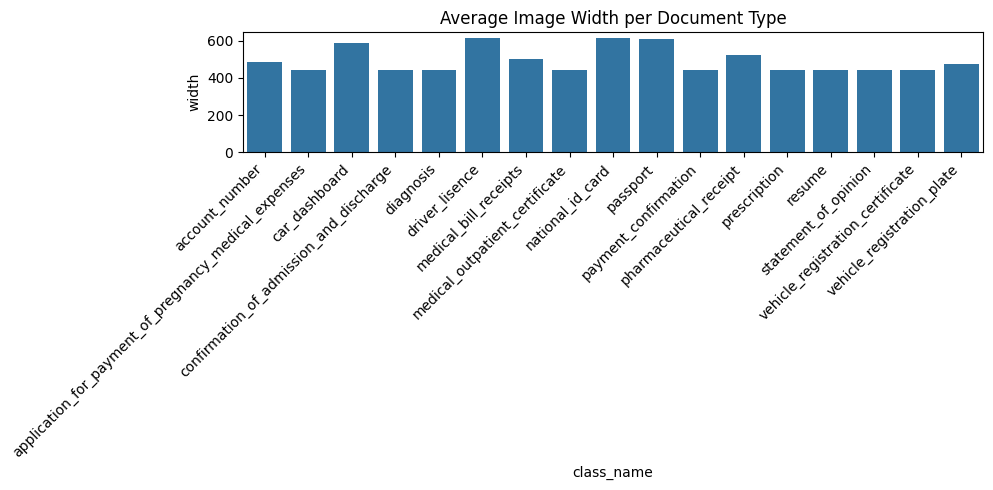


✅ EDA Summary
- Train Samples: 1570
- Unique Labels: 17
- Class Names: 17
- Image Samples Scanned: 1570
- Average Resolution: 497.6 x 538.2
✨ EDA 완료!


In [1]:
# =========================================================
# 📊 Document Image EDA - Full Pipeline
# =========================================================

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# ---------------------------------------------------------
# 0️⃣ 경로 설정
# ---------------------------------------------------------
BASE_DIR = '/root/cv_project/data'
TRAIN_CSV = os.path.join(BASE_DIR, 'train.csv')
META_CSV = os.path.join(BASE_DIR, 'meta.csv')
FOLDS_CSV = os.path.join(BASE_DIR, 'train_folds.csv')
SAMPLE_CSV = os.path.join(BASE_DIR, 'sample_submission.csv')
IMG_DIR = os.path.join(BASE_DIR, 'train')

# ---------------------------------------------------------
# 1️⃣ 데이터 로드
# ---------------------------------------------------------
print("🔹 CSV 파일 로드 중...")
train = pd.read_csv(TRAIN_CSV)
meta = pd.read_csv(META_CSV)
folds = pd.read_csv(FOLDS_CSV)
sample = pd.read_csv(SAMPLE_CSV)

print(f"train: {train.shape}, meta: {meta.shape}, folds: {folds.shape}, sample: {sample.shape}")
print("train columns:", list(train.columns))
print("meta columns:", list(meta.columns))

# ---------------------------------------------------------
# 2️⃣ 컬럼명 자동 탐색
# ---------------------------------------------------------
def find_column(df, keywords):
    for key in keywords:
        for col in df.columns:
            if key in col.lower():
                return col
    return None

label_col = find_column(train, ['label', 'target', 'class'])
id_col = find_column(train, ['id', 'file', 'path', 'image'])

if label_col is None:
    raise ValueError(f"❌ 라벨 컬럼을 찾을 수 없습니다. ({list(train.columns)})")
if id_col is None:
    raise ValueError(f"❌ 이미지 ID 컬럼을 찾을 수 없습니다. ({list(train.columns)})")

print(f"✅ label_col = {label_col}")
print(f"✅ id_col = {id_col}")

# ---------------------------------------------------------
# 3️⃣ 클래스 분포 시각화
# ---------------------------------------------------------
plt.figure(figsize=(10,5))
sns.countplot(y=label_col, data=train, order=train[label_col].value_counts().index)
plt.title("Document Label Distribution")
plt.xlabel("Count")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4️⃣ meta.csv 매핑 (target ↔ class_name)
# ---------------------------------------------------------
if {'target', 'class_name'}.issubset(meta.columns):
    merged = train.merge(meta, left_on=label_col, right_on='target', how='left')
    plt.figure(figsize=(10,5))
    sns.countplot(y='class_name', data=merged, order=merged['class_name'].value_counts().index)
    plt.title("Document Type Distribution by Class Name")
    plt.xlabel("Count")
    plt.ylabel("Document Type")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ meta.csv에 'target', 'class_name' 컬럼이 없어 스킵합니다.")

# ---------------------------------------------------------
# 5️⃣ 이미지 크기 / 비율 분석
# ---------------------------------------------------------
print("\n🔹 이미지 크기 분석 중...")
widths, heights = [], []
for name in train[id_col]:
    name = str(name)
    if not name.lower().endswith(('.jpg', '.jpeg', '.png')):
        name = f"{name}.jpg"
    path = os.path.join(IMG_DIR, name)
    if os.path.exists(path):
        with Image.open(path) as im:
            w, h = im.size
            widths.append(w)
            heights.append(h)

if len(widths) > 0:
    df_size = pd.DataFrame({'width': widths, 'height': heights})
    df_size['aspect_ratio'] = df_size['width'] / df_size['height']

    plt.figure(figsize=(6,4))
    sns.scatterplot(x='width', y='height', data=df_size, alpha=0.5)
    plt.title('Image Resolution Distribution')
    plt.xlabel('Width'); plt.ylabel('Height')
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    sns.histplot(df_size['aspect_ratio'], bins=30, kde=True)
    plt.title('Aspect Ratio Distribution')
    plt.xlabel('Width / Height Ratio')
    plt.tight_layout(); plt.show()

    print(f"📏 평균 해상도: {np.mean(widths):.1f} x {np.mean(heights):.1f}")
else:
    print("⚠️ 이미지 파일을 찾지 못했거나 폴더가 비어 있습니다.")

# ---------------------------------------------------------
# 6️⃣ Fold별 데이터 균형 확인
# ---------------------------------------------------------
fold_col = find_column(folds, ['fold'])
label_col_in_folds = find_column(folds, ['label', 'target', 'class'])

if fold_col and label_col_in_folds:
    plt.figure(figsize=(8,4))
    sns.countplot(x=fold_col, hue=label_col_in_folds, data=folds)
    plt.title("Label Distribution per Fold")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ folds.csv에 fold/label 관련 컬럼이 없습니다.")

# ---------------------------------------------------------
# 7️⃣ Train/Test 데이터 수 & ID 형식 비교
# ---------------------------------------------------------
print("\n🔹 Train/Test 비교")
print(f"Train 이미지 수: {len(train)}")
print(f"Test  이미지 수: {len(sample)}")

test_id_col = find_column(sample, ['id', 'file'])
if test_id_col:
    print("Train ID 예시:", train[id_col].iloc[0])
    print("Test  ID 예시:", sample[test_id_col].iloc[0])
else:
    print("⚠️ sample_submission.csv에서 ID 컬럼을 찾지 못했습니다.")

# ---------------------------------------------------------
# 8️⃣ 라벨별 평균 해상도 (meta 결합)
# ---------------------------------------------------------
if len(widths) > 0 and {'target', 'class_name'}.issubset(meta.columns):
    merged_stats = train.merge(meta, left_on=label_col, right_on='target', how='left')
    merged_stats['width'] = df_size['width'][:len(merged_stats)]
    merged_stats['height'] = df_size['height'][:len(merged_stats)]

    agg = merged_stats.groupby('class_name')[['width', 'height']].mean().reset_index()

    plt.figure(figsize=(10,5))
    sns.barplot(x='class_name', y='width', data=agg)
    plt.xticks(rotation=45, ha='right')
    plt.title('Average Image Width per Document Type')
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# ✅ 요약 리포트
# ---------------------------------------------------------
print("\n✅ EDA Summary")
print(f"- Train Samples: {len(train)}")
print(f"- Unique Labels: {train[label_col].nunique()}")
if 'class_name' in meta.columns:
    print(f"- Class Names: {meta['class_name'].nunique()}")
print(f"- Image Samples Scanned: {len(widths)}")
if len(widths) > 0:
    print(f"- Average Resolution: {np.mean(widths):.1f} x {np.mean(heights):.1f}")
print("✨ EDA 완료!")
